In [45]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tqdm import tqdm

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# Setup & Configuration
IMG_WIDTH, IMG_HEIGHT = 224, 224
IMAGE_FOLDER = '/content/drive/MyDrive/DR_Project/train_images'
CSV_FILE = '/content/drive/MyDrive/DR_Project/Retina.csv' # Using the new CSV file

In [52]:
# Load dataset labels
df = pd.read_csv(CSV_FILE)
print(f"\nDataset Information:")
print(f"Shape: {df.shape}")
print(f"Total images: {len(df)}")
print(f"Features: {df.columns.tolist()}")


Dataset Information:
Shape: (1100, 2)
Total images: 1100
Features: ['id_code', 'diagnosis']


In [53]:
print("\nFirst 5 samples:")
print(df.head())


First 5 samples:
   id_code  diagnosis
0        1          2
1        2          4
2        3          1
3        4          0
4        5          0


In [54]:
print("\nDataset Statistics:")
print(df.describe())


Dataset Statistics:
           id_code    diagnosis
count  1100.000000  1100.000000
mean    550.500000     1.186364
std     317.686953     1.294910
min       1.000000     0.000000
25%     275.750000     0.000000
50%     550.500000     1.000000
75%     825.250000     2.000000
max    1100.000000     4.000000


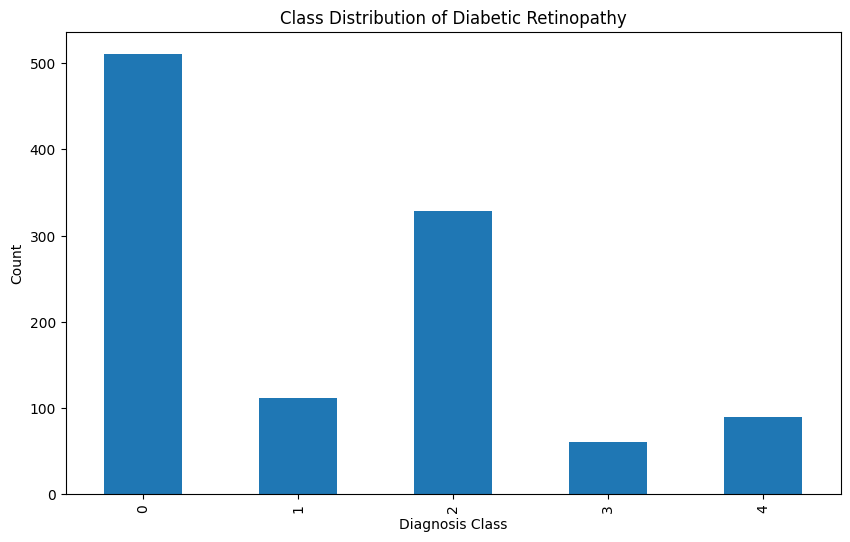

In [55]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
df['diagnosis'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution of Diabetic Retinopathy')
plt.xlabel('Diagnosis Class')
plt.ylabel('Count')
plt.show()

In [56]:
# CNN Feature Extraction (Image Processing - EfficientNetB0)
print("Loading EfficientNetB0 Model for feature extraction...")
# Load EfficientNetB0 without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(dataframe, img_folder):
    features_list = []
    labels_list = []

    print("Extracting features from images...")
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        # Construct filename. Check your specific extension (.png, .jpg)
        img_name = str(row['id_code']) + '.png'
        img_path = os.path.join(img_folder, img_name)

        if os.path.exists(img_path):
            try:
                # Load, Resize, and Preprocess (uses EfficientNet's specific preprocessing)
                img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)

                # Extract features
                features = model.predict(x, verbose=0)
                features_flat = features.flatten()

                features_list.append(features_flat)
                labels_list.append(row['diagnosis'])
            except Exception as e:
                print(f"Error processing {img_name}: {e}")

    return np.array(features_list), np.array(labels_list)

Loading EfficientNetB0 Model for feature extraction...


In [57]:
if os.path.exists(IMAGE_FOLDER):
    X, y = extract_features(df, IMAGE_FOLDER)

    # Balanced Random Forest Classification
    if len(X) > 0:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train Random Forest Model (class_weight='balanced' is critical for imbalance)
        print("Training Balanced Random Forest Classifier...")
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        rf_model.fit(X_train, y_train)

        # Predict
        y_pred = rf_model.predict(X_test)

        # Predict Only Accuracy & Evaluation Metrics
        acc = accuracy_score(y_test, y_pred)
        print("\n" + "="*50)
        print(f"Final Accuracy: {acc}")
        print("="*50)

        # Generate Classification Report (Precision, Recall, F1-Score per class)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Save model for Streamlit
        with open('rf_model.pkl', 'wb') as f:
            pickle.dump(rf_model, f)
        print("Model saved as rf_model_efficientnet.pkl")

    else:
        print("No features extracted. Check data loading steps.")
else:
    print(f"Image folder '{IMAGE_FOLDER}' not found. Please upload your dataset.")

Extracting features from images...


100%|██████████| 1100/1100 [00:34<00:00, 31.45it/s] 


Training Balanced Random Forest Classifier...

Final Accuracy: 0.45

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           2       0.35      1.00      0.52         6
           3       0.00      0.00      0.00         2

    accuracy                           0.45        20
   macro avg       0.45      0.42      0.31        20
weighted avg       0.71      0.45      0.40        20

Model saved as rf_model_efficientnet.pkl


In [58]:
from google.colab import files

# Downloads the model file
files.download('rf_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>